# Analiza semiwariogramu

Interpolacja za pomocą zautomatyzowanego Krigingu bez wcześniejszej analizy semiwariogramu to zły pomysł. Kriging zwróci "jakieś" wyniki, niezależnie od tego czy proces który modelujesz jest powiązany z lokacjami, czy nie. Najłatwiej i najbezpieczniej jest trzymać człowieka w pętli i uniknąć nieprzyjemnych niespodzianek przy zdawaniu raportu albo podejmowaniu decyzji.

Co robi człowiek w pętli? Analizuje i dopasowuje semiwariogram. Semiwariogram odpowie, czy modelowany proces może być opisany w funkcji dystansu między poszczególnymi pomiarami i jak silne są zależności między wartościami sąsiadujących obserwacji.

W pierwszym ćwiczeniu własnoręcznie przeprowadzisz analizę semiwariogramu i zadecydujesz jak dalej modelować dane przestrzenne.

## Minimalne wymagania do zrozumienia samouczka

- **Wiedza domenowa**:
  - semiwariancja i kowariancja
- **Biblioteka**:
  - instalacja `pyinterpolate`
- **Programowanie**:
  - podstawy Pythona

## Spis treści

1. Przygotowanie danych
2. Stworzenie eksperymentalnego semiwariogramu
3. Ręczne dopasowanie teoretycznych modeli semiwariogramu
4. Automatyczne dopasowanie modelu teoretycznego
5. Eksport/zapis dopasowanego modelu
6. Import/wczytwanie dopasowanego modelu

## Zbiór danych

Zbiorem danych jest cyfrowy model rzeźby terenu (DEM - Digital Elevation Model) w okolicy Gorzowa Wielkopolskiego w Polsce.

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pyinterpolate import reproject_flat, ExperimentalVariogram, build_theoretical_variogram, TheoreticalVariogram

## Przygotowanie danych

In [9]:
DEM_FILE = '../../../data/dem.csv'

In [10]:
df = pd.read_csv(DEM_FILE)
df.head()

,longitude,latitude,dem
0,15.115241,52.765146,91.275597
1,15.115241,52.742790,96.548294
2,15.115241,52.710706,51.254551
3,15.115241,52.708844,48.958282
4,15.115241,52.671378,16.817863


Projekcja danych (`EPSG:4326`) jest oparta na miarych kątowych i niewiernie odwzorowuje odległości, a modelowanie semiwariogramu opiera się obliczaniu dystansu między parami punktów. Z tego względu zaleca jest transformacja do metrycznego układu odwzorowań, dla Polski będzie to na przykład `EPSG:2180`.

Koordynaty danych zapisane są w dwóch kolumnach `longitude` i `latitude`. Najwygodniej jest je złączyć w jeden obiekt typu `shapely.Point()`, a następnie przeprowadzić transformację do EPSG:2180. Możesz to zrobić ręcznie albo zastosować funkcję `reproject_flat()` pakietu `pyinterpolate` jak w przykładzie poniżej.

In [11]:
r_df = reproject_flat(
    ds=df,
    in_crs=4326,
    out_crs=2180,
    lon_col='longitude',
    lat_col='latitude'
)

In [12]:
r_df.head()

,dem,longitude,latitude
0,91.275597,238012.301750,551466.805222
1,96.548294,237878.001294,548982.351111
2,51.254551,237685.325393,545416.708315
3,48.958282,237674.140301,545209.671315
4,16.817863,237449.254870,541045.934750


Wygodnie jest przekształcić obiekt typu `DataFrame` w którym przechowywane są wartości DEM do `GeoDataFrame`, przede wszystkim ze względu możliwości rysowania powierzchni.

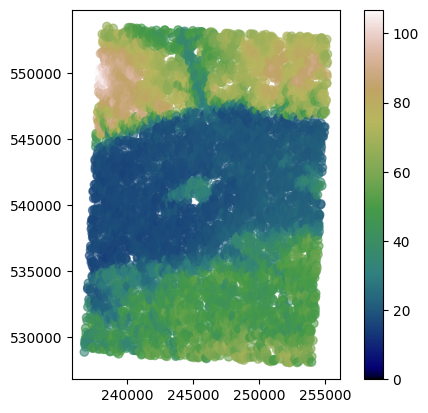

In [13]:
dem_geometry = gpd.points_from_xy(x=r_df['longitude'], y=r_df['latitude'], crs=2180)
dem = gpd.GeoDataFrame(r_df, geometry=dem_geometry)

dem.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);

Dane pokrywają praktycznie cały obszar, ale taki scenariusz nie jest realistyczny dla zadań geostatystyki. Zgodnie z praktycznymi scenariuszami, odcięte zostanie 99% wartości z istniejącego zbioru, a do modelowania zastosowany będzie tylko 1% próbek.

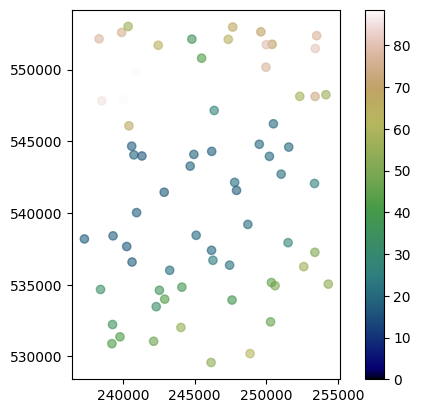

In [14]:
sample = dem.sample(int(0.01 * len(dem)))
sample.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);

## Eksperymentalny semiwariogram

Interpolacja Krigingu zakłada, że między parą obserwacji występuje relacja oparta na odległości. Sprawdzenie tej relacji przed modelowaniem chroni przed wynikami, które *wyglądają* na właściwe, ale takie nie są. Narysowanie semiwariogramu to jedna z metod ewaluacji miary (nie)podobieństwa par w funkcji dystansu.

Mówiąc o semiwariogramie, można pomyśleć o dwóch różnych wykresach:

- **Eksperymentaly semiwariogram** to wykres punktowy, który pokazuje uśrednione wartości semiwariancji między parami punktów w określonych przedziałach odległości (z ang.: *lags*), jeśli te przedziały są zbyt wąskie, możemy otrzymać mocno zaszumiony wykres, a jeśli są za szerokie, krzywa będzie nadmiernie wygładzona.
- **Teoretyczny semiwariogram** to funkcja, która minimalizuje błąd między krzywą tej funkcji a punktami eksperymentalnego semiwariogramu. To nie może być każda funkcja - w literaturze spotykamy się z kilkunastoma funkcjami, najważniejsze z nich są zaimplementowane w `pyinterpolate`. Stworzenie teoretycznego semiwariogramu wymaga wcześniejszego obliczenia eksperymentalnego semiwariogramu.

Eksperymentalny semiwariogram jest tworzony przy pomocy klasy `ExperimentalVariogram` albo funkcji `build_experimental_variogram()`. Klasa przyjmuje następujące parametry przy inicjalizacji:

- `ds` : numpy array - ``[x, y, wartość obserwacji]``
- `step_size` : float - szerokość przedziału odległości gdzie grupujemy semiwariancje między parami punktów.
- `max_range` : float - maksymalny dystans dla jakiego modelujemy semiwariancje, nie powinien to być maksymalny możliwy dystans między obserwacjami.
- `direction` : float, opcjonalny - kierunek semiwariogramu, domyślnie semiwariogram jest izotropowy - nie ma wyróżnionego kierunku - ale niektóre procesy fizyczne mają taki kierunek.
- `tolerance` : float, opcjonalny - parametr wpływający na kształt okna (elipsy, trójkąta) kierunkowego wyboru sąsiednich punktów.
- `dir_neighbors_selection_method` : str, domyślnie = 't' - metoda wyboru sąsiadów dla kierunkowego wariogramu.
- `custom_bins` : numpy array, opcjonalny - przedziały odległości zdefiniowane przez użytkownika, mogą mieć różną szerokość.
- `custom_weights` : numpy array, opcjonalny - dodatkowe wagi dla każdego z punktów, wpływają na semiwariancję.
- `is_semivariance` : bool, domyślnie=True - oblicza eksperymentalną semiwariancję.
- `is_covariance` : bool, domyślnie=True - oblicza eksperymentalną kowariancję.
- `as_cloud` : bool, domyślnie=False - nie uśrednia semiwariancji do okna odległości, co pozwala na wizualizację chmury punktów eksperymantalnej semiwariancji.

Parametry `direction`, `tolerance`, `dir_neighbors_selection_method`, `custom_bins`, `custom_weights` i `as_cloud` nie będą na razie używane.

In [8]:
step_size = 1000  # meters - remember, that this parameter is related to projection!
max_range = 20000  # meters - remember, that this parameter is related to projection!

is_semivariance = True
is_covariance = True

ds = sample[['longitude', 'latitude', 'dem']].to_numpy()

In [9]:
experimental_variogram = ExperimentalVariogram(
    ds=ds,
    step_size=step_size,
    max_range=max_range,
    is_semivariance=is_semivariance,
    is_covariance=is_covariance
) 

Obiekt `ExperimentalVariogram` reprezentuje:

- **semivariance** (semiwariancję): miara niepodobieństwa punktów w funkcji odległości,
- **covariance** (kowariancję): miara podobieństwa punktów w funkcji odległości,
- **variance** (wariancję): całkowita wariancja zbioru wejściowego, niezależna od dystansu.

Pozostałe użyteczne metody klasy to:

1. `print()` - do wyświetlenia informacji statystycznych w formie tekstowej.
2. `.plot()` - do wykreślania semiwariancji, kowariancji i wariancji.

In [10]:
print(experimental_variogram)

+---------+--------------------+---------------------+
|   lag   |    semivariance    |      covariance     |
+---------+--------------------+---------------------+
|  1000.0 | 66.50350756874842  |  573.8969420596828  |
|  2000.0 |  95.8495480710881  |  419.32956877520513 |
|  3000.0 | 216.36902963659804 |  346.8044015563413  |
|  4000.0 | 200.3351196859388  |  345.7406543587138  |
|  5000.0 | 328.1104528782418  |  261.58692115765933 |
|  6000.0 | 360.32608183289074 |  135.3561859868873  |
|  7000.0 | 499.7581649946207  |  42.906703056558335 |
|  8000.0 | 494.7692801878459  |  -37.13003621033862 |
|  9000.0 |  737.895544254725  | -173.04103246328214 |
| 10000.0 |  549.939216528212  |  -78.5811036652226  |
| 11000.0 | 813.1542867553994  | -217.55107310356686 |
| 12000.0 | 653.6083701575303  | -133.11955761301863 |
| 13000.0 |  800.280913144602  | -249.20324106610195 |
| 14000.0 | 798.5233842803291  |  -269.8549895665524 |
| 15000.0 | 672.2006358211872  | -123.40731524633007 |
| 16000.0 

- **Lag** to kolumna z centrum danego przedziału,
- **semivariance** kolumna reprezentująca miarę niepodobieństwa,
- **covariance** kolumna reprezentująca podobieństwo.

Możesz wykreślić semiwariancję i kowariancję by zobaczyć zależność między nimi.

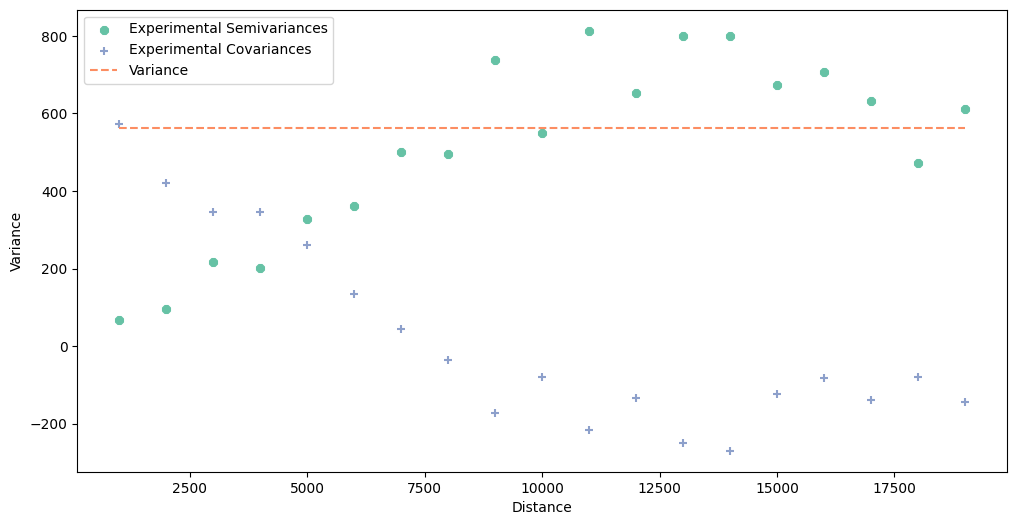

In [11]:
experimental_variogram.plot(
    semivariance=True,
    covariance=True,
    variance=True
)

Wykres pokazuje trzy rzeczy:

- **Koła** - semiwariancję
- **Plusy** - kowariancję
- **Przerywana linia** - wariancja

Semiwariancja i kowariancja są względem siebie symetrycznie odbite. Co to oznacza w praktyce? To jest normalne zachowanie, z czego semiwariancja pokazuje niepodobieństwo w funkcji dystansu (pary położone blisko siebie są bardziej podobne niż pary odległe), a kowariancja odwrotnie. Możemy łatwo przekształcić jedno w drugie i dla części obliczeń ma to znaczenie.

W najlepszym scenariuszu (dane są stacjonarne, średnia i wariancja nie zmieniają się wraz z odległością), suma wariancji i kowariancji powinna być równa semiwariancji.

## Teoretyczny semiwariogram

### Ręczne ustawienie

Mając eksperymentalny wariogram możesz przejść do dopasowania krzywej teoretycznej - *teoretycznego semiwariogramu* - do obserwowanych punktów. Proces może być automatyczny albo manualny.

Teoretyczny semiwariogram jest opisany przez trzy parametry: *nugget*, *sill*, *range*:

- **nugget**: bazowa wartość semiwariancji dla dystansu 0, zwykle jest to 0, ale czasami wartość większa od zera reprezentująca niepewność pomiarową.
- **sill**: dystans, przy którym semiwariogram "wypłaszcza się" i osiąga ok. 95% wartości niepodobieństwa. Czasami znalezienie tego parametru nie jest możliwe, przykładem jest teoretyczny semiwariogram modelowany przez funkcję wykładniczą. Nie ma on konkretnej granicy, więc wartość ta jest modelowana bliżej wariancji niż teoretycznej granicy.
- **range**: odległość, dla której semiwariogram wypłaszcza się (osiąga **sill**).

Nie jesteś zmuszony, żeby znać te wartości od początku, są one znajdowane metodą `TheoriticalVariogram.autofit()`. Stąd istnieją dwie możliwości dopasowania teoretycznego semiwariogramu:

1. Ręcznie, określając typ modelu, *nugget*, *sill* i *range*.
2. Pół-automatycznie, uzupełniając tylko wybrane parametry.

### Typy modeli

Do wyboru mamy kilka predefiniowanych typów funkcji (modeli) semiwariogramu:

- circular
- cubic
- exponential
- gaussian
- linear
- power
- spherical

Utworzymy semiwariogramy dla każdej z nich ustawiając pozostałe na następujące wartości:

- **sill** równe eksperymentalnej wariancji, (inną opcją jest dobranie tego parameteru jako średniej z n-ostatnich obserwacji eksperymentalnego semiwariogramu),
- **nugget** na zero,
- **range** na 8000 (eksperymentalny semiwariogram wypłaszcza się w tym miejscu i dalej wagi są już raczej stałe).

In [12]:
sill = experimental_variogram.variance
nugget = 0
variogram_range = 8000

In [13]:
# circular

circular_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                             models_group='circular',
                                             sill=sill,
                                             rang=variogram_range,
                                             nugget=nugget)

In [14]:
print(circular_model)

* Selected model: Circular model
* Nugget: 0
* Sill: 562.0482965706882
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 129.9549217265119
* Error-lag weighting dir_neighbors_selection_method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 89.21926570120685  | 66.50350756874842  | -22.715758132458433 |
|  2000.0 | 177.0240565312119  |  95.8495480710881  |  -81.1745084601238  |
|  3000.0 | 261.92881517059374 | 216.36902963659804 | -45.559785533995694 |
|  4000.0 | 342.2861654512381  | 200.3351196859388  |  -141.9510457652993 |
|  5000.0 | 416.1421335800296  | 328.1104528782418  |  -88.03168070178782 |
|  6000.0 | 480.9483172823313  | 360.32608183289074 | -120.62223544944055 |
|  7000.0 | 532.7961845551719  | 499.7581

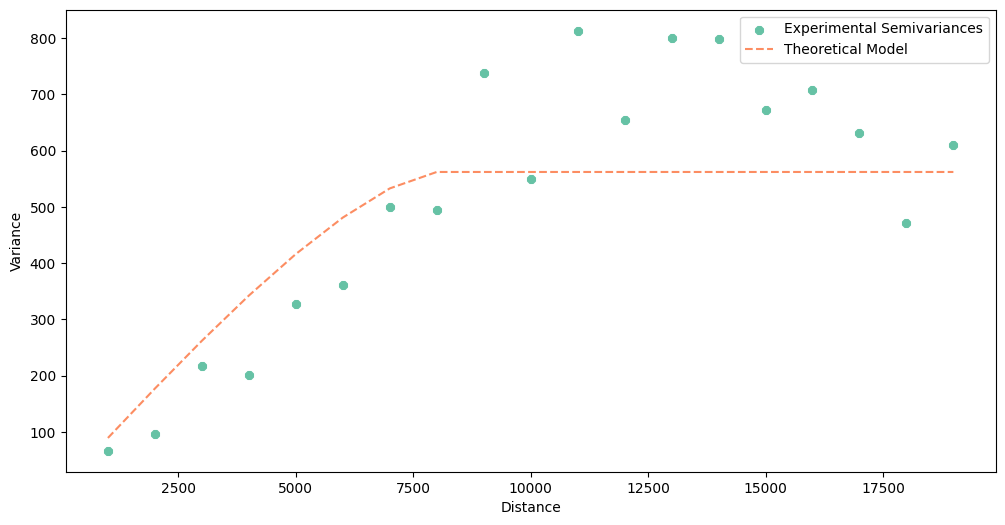

In [15]:
circular_model.plot()

In [16]:
# cubic

cubic_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                          models_group='cubic',
                                          sill=sill,
                                          rang=variogram_range,
                                          nugget=nugget)

In [17]:
print(cubic_model)

* Selected model: Cubic model
* Nugget: 0
* Sill: 562.0482965706882
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 146.08948321088144
* Error-lag weighting dir_neighbors_selection_method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 51.928547099740086 | 66.50350756874842  |  14.574960469008332 |
|  2000.0 | 170.94892418737072 |  95.8495480710881  |  -75.09937611628263 |
|  3000.0 | 308.0711976064423  | 216.36902963659804 |  -91.70216796984425 |
|  4000.0 | 427.02497532421427 | 200.3351196859388  | -226.68985563827547 |
|  5000.0 | 508.0865256502935  | 328.1104528782418  | -179.97607277205168 |
|  6000.0 | 548.8667134434124  | 360.32608183289074 |  -188.5406316105217 |
|  7000.0 | 561.0466929690614  | 499.758164

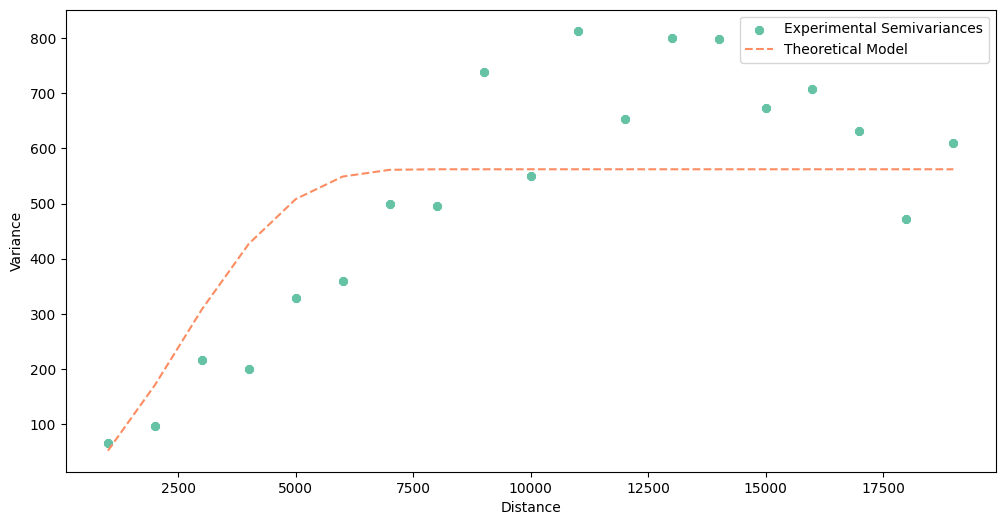

In [18]:
cubic_model.plot()

In [19]:
# Exponential model

exponential_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                                models_group='exponential',
                                                sill=sill,
                                                rang=variogram_range,
                                                nugget=nugget)
print(exponential_model)

* Selected model: Exponential model
* Nugget: 0
* Sill: 562.0482965706882
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 200.42906080741184
* Error-lag weighting dir_neighbors_selection_method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 66.04241574410776  | 66.50350756874842  | 0.46109182464066123 |
|  2000.0 | 124.32464307748702 |  95.8495480710881  |  -28.47509500639893 |
|  3000.0 | 175.75852817492543 | 216.36902963659804 |  40.61050146167261  |
|  4000.0 | 221.14877246130683 | 200.3351196859388  |  -20.81365277536804 |
|  5000.0 | 261.20552245159655 | 328.1104528782418  |  66.90493042664525  |
|  6000.0 | 296.55548024563274 | 360.32608183289074 |   63.770601587258   |
|  7000.0 | 327.7517085053658  | 499.

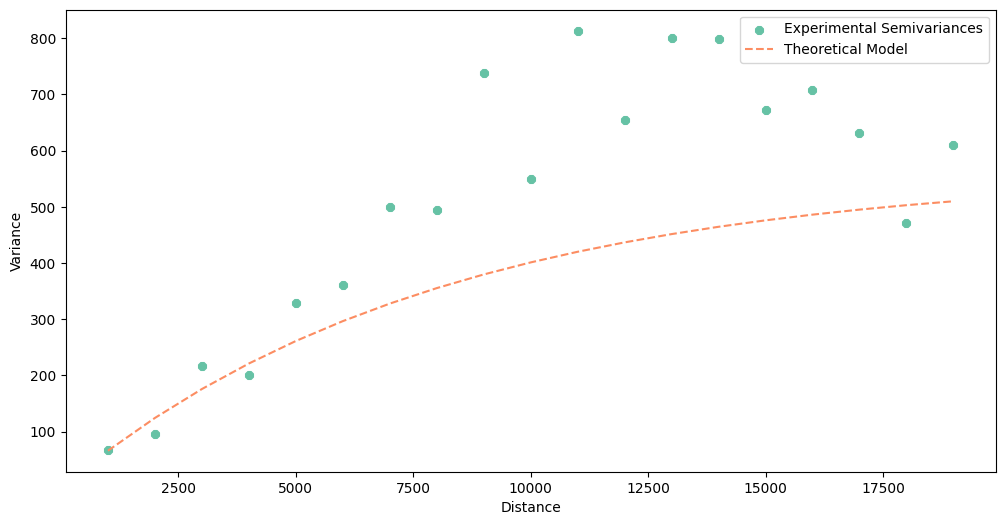

In [20]:
exponential_model.plot()

In [21]:
# Gaussian model

gaussian_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                             models_group='gaussian',
                                             sill=sill,
                                             rang=variogram_range,
                                             nugget=nugget)
print(gaussian_model)

* Selected model: Gaussian model
* Nugget: 0
* Sill: 562.0482965706882
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 176.05298225928948
* Error-lag weighting dir_neighbors_selection_method: equal


+---------+--------------------+--------------------+--------------------+
|   lag   |    theoretical     |    experimental    |  bias (real-yhat)  |
+---------+--------------------+--------------------+--------------------+
|  1000.0 | 8.713751171886535  | 66.50350756874842  | 57.78975639686188  |
|  2000.0 | 34.052784840121205 |  95.8495480710881  | 61.79676323096689  |
|  3000.0 | 73.73227416319057  | 216.36902963659804 | 142.63675547340748 |
|  4000.0 | 124.32464307748702 | 200.3351196859388  | 76.01047660845177  |
|  5000.0 | 181.74739593341536 | 328.1104528782418  | 146.36305694482644 |
|  6000.0 | 241.80283051543793 | 360.32608183289074 | 118.5232513174528  |
|  7000.0 | 300.6715648481398  | 499.758164994620

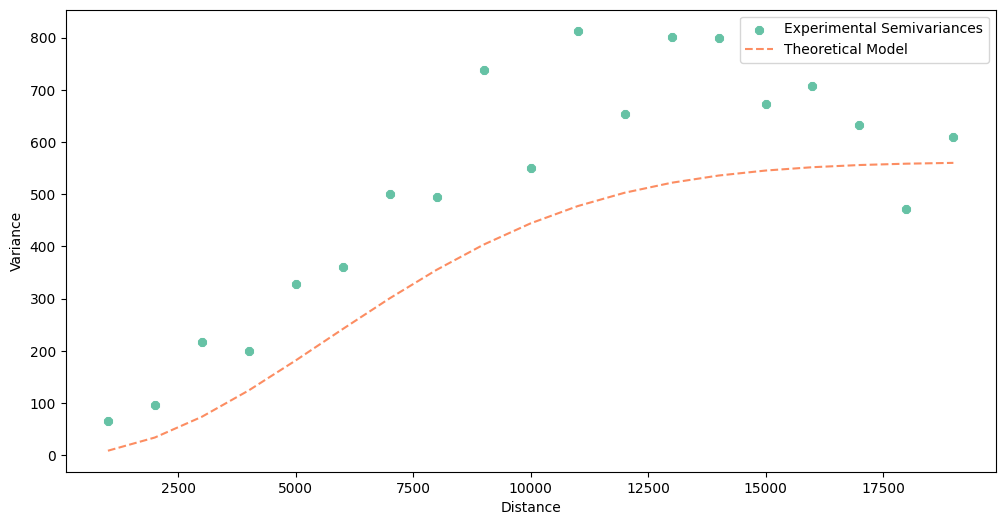

In [22]:
gaussian_model.plot()

In [23]:
# Linear model

linear_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                           models_group='linear',
                                           sill=sill,
                                           rang=variogram_range,
                                           nugget=nugget)
print(linear_model)

* Selected model: Linear model
* Nugget: 0
* Sill: 562.0482965706882
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 121.6235188837861
* Error-lag weighting dir_neighbors_selection_method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 70.25603707133602  | 66.50350756874842  |  -3.752529502587606 |
|  2000.0 | 140.51207414267205 |  95.8495480710881  | -44.662526071583954 |
|  3000.0 | 210.76811121400806 | 216.36902963659804 |  5.600918422589984  |
|  4000.0 | 281.0241482853441  | 200.3351196859388  |  -80.6890285994053  |
|  5000.0 | 351.28018535668014 | 328.1104528782418  | -23.169732478438334 |
|  6000.0 | 421.5362224280161  | 360.32608183289074 |  -61.21014059512538 |
|  7000.0 | 491.79225949935216 | 499.758164

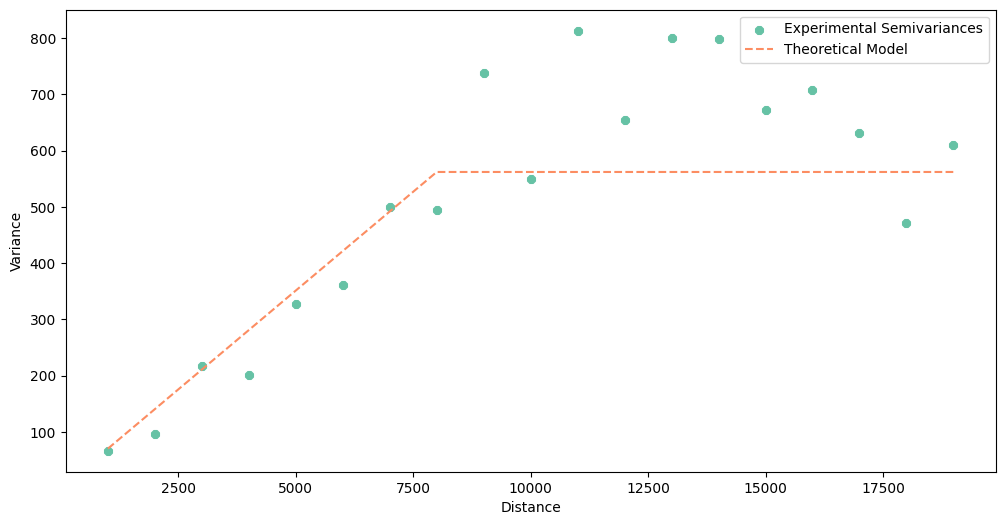

In [24]:
linear_model.plot()

In [25]:
# Power model

power_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                          models_group='power',
                                          sill=sill,
                                          rang=variogram_range,
                                          nugget=nugget)
print(power_model)

* Selected model: Power model
* Nugget: 0
* Sill: 562.0482965706882
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 128.99847007753777
* Error-lag weighting dir_neighbors_selection_method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 8.782004633917003  | 66.50350756874842  |  57.72150293483141  |
|  2000.0 | 35.12801853566801  |  95.8495480710881  |  60.72152953542008  |
|  3000.0 | 79.03804170525302  | 216.36902963659804 |  137.33098793134502 |
|  4000.0 | 140.51207414267205 | 200.3351196859388  |  59.823045543266744 |
|  5000.0 | 219.55011584792507 | 328.1104528782418  |  108.56033703031673 |
|  6000.0 | 316.1521668210121  | 360.32608183289074 |  44.17391501187865  |
|  7000.0 | 430.31822706193316 | 499.758164

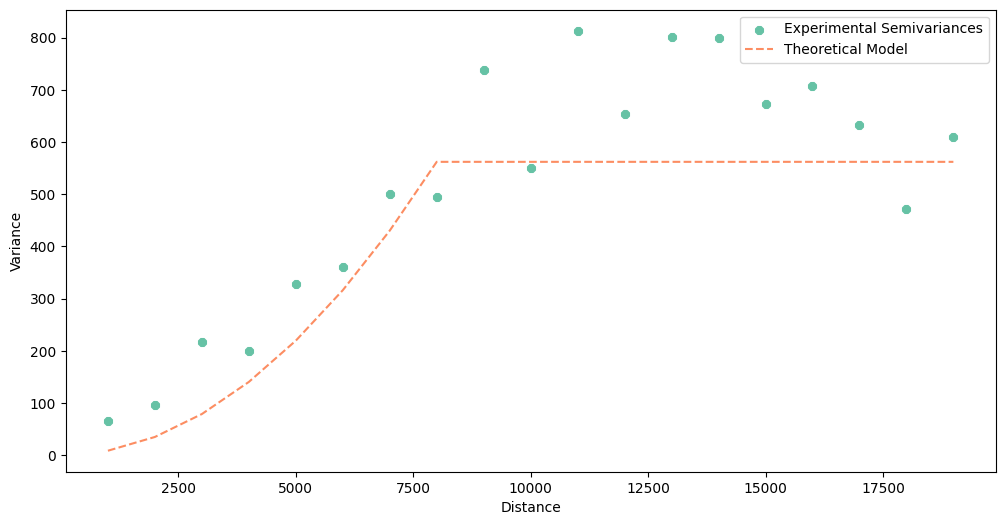

In [26]:
power_model.plot()

In [27]:
# Spherical model

spherical_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                              models_group='spherical',
                                              sill=sill,
                                              rang=variogram_range,
                                              nugget=nugget)

print(spherical_model)

* Selected model: Spherical model
* Nugget: 0
* Sill: 562.0482965706882
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 138.91307581152344
* Error-lag weighting dir_neighbors_selection_method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 104.83518031738423 | 66.50350756874842  |  -38.33167274863581 |
|  2000.0 | 206.37710889704957 |  95.8495480710881  | -110.52756082596147 |
|  3000.0 | 301.33253400127717 | 216.36902963659804 |  -84.96350436467912 |
|  4000.0 | 386.4082038923481  | 200.3351196859388  | -186.07308420640933 |
|  5000.0 | 458.3108668325436  | 328.1104528782418  | -130.20041395430178 |
|  6000.0 | 513.7472710841447  | 360.32608183289074 | -153.42118925125396 |
|  7000.0 | 549.4241649094325  | 499.75

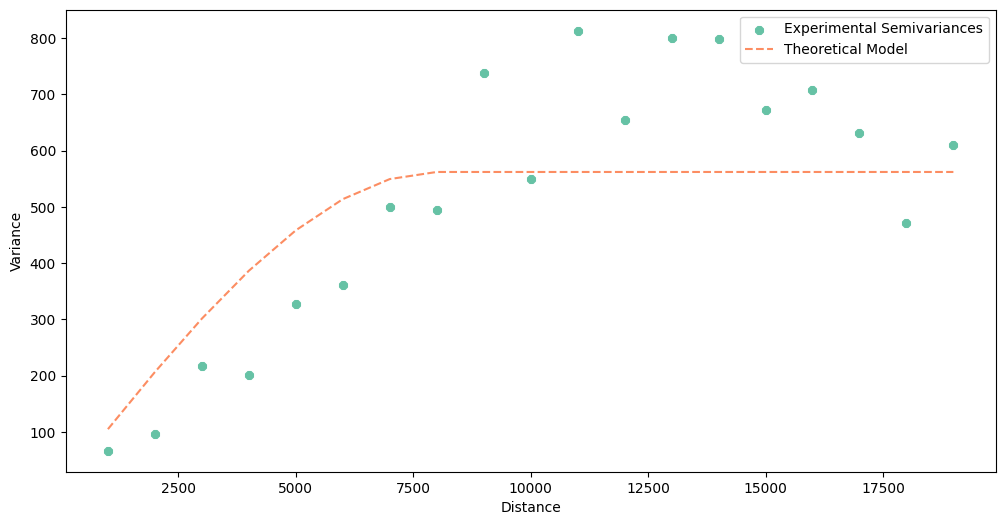

In [28]:
spherical_model.plot()

Zgodnie z minimalizacją pierwiastka ze średniego błędu kwadratowego (RMSE) między teoretyczną krzywą a eksperymentalnymi punktami najlepszym modelem jest liniowy. Można tak zgadywać przeglądając wykresy, ale lepiej automatycznie porównać RMSE między modelami jak w komórce poniżej.

In [29]:
models = [
    circular_model, cubic_model, exponential_model, gaussian_model, linear_model, power_model, spherical_model
]

lowest_rmse = np.inf
chosen_model = ''

for _model in models:
    
    # Get attrs
    model_name = _model.name
    model_rmse = _model.rmse
    
    # Check error
    if model_rmse < lowest_rmse:
        lowest_rmse = model_rmse
        chosen_model = model_name
    
    # Print status
    msg = f'Model: {model_name}, RMSE: {model_rmse}'
    print(msg)

msg = f'\nThe best model is {chosen_model} with RMSE {lowest_rmse}'
print(msg)

Model: circular, RMSE: 129.9549217265119
Model: cubic, RMSE: 146.08948321088144
Model: exponential, RMSE: 200.42906080741184
Model: gaussian, RMSE: 176.05298225928948
Model: linear, RMSE: 121.6235188837861
Model: power, RMSE: 128.99847007753777
Model: spherical, RMSE: 138.91307581152344

The best model is linear with RMSE 121.6235188837861


## Automatyczne dopasowanie teoretycznego semiwariogramu

Semiwariogram można dopasować automatycznie, wystarczy pozostawić parametry sterujące funkcji `build_variogram_model()` niewypełnione. Funkcja przyjmuje następuje parametry:

- `experimental_variogram` - obliczony eksperymentalny semiwariogram (`ExperimentalVariogram`)
- `models_group` - to może być nazwa funkcji modelującej, albo specjalny alias. Domyślnie jest to alias, `safe`, który porównuje trzy "bezpieczne" mapowania. Pełna lista opcji:
    - `'all'`: testuje wszystkie typy modeli,
    - `'safe'`: `['linear', 'power', 'spherical']`
    - jako lista wybranych nazw (poniżej)
    - jako tekst oznaczający konkretną funkcję:
      - `'circular'`
      - `'cubic'`
      - `'exponential'`
      - `'gaussian'`
      - `'linear'`
      - `'power'`
      - `'spherical'`
- `nugget` - nugget (bias) semiwariogramu
- `min_nugget` - domyślnie = 0.0 - czynnik skalujący bazowy nugget i określający dolną granicę poszukiwania tego wskaźnika
- `max_nugget` - domyślnie = 0.5 - czynnik skalujący bazowy nugget i określający górną granicę poszukiwania tego wskaźnika
- `number_of_nuggets` - domyślnie = 16 - liczba przedziałów między `min_nugget` a `max_nugget` do sprawdzenia
- `rang` - zasięg (*range*) semiwariogramu, jeśli podany, to jest ustawiony sztywno na tę wartość
- `min_range` - domyślnie = 0.1 - minimalny zasięg od którego zaczyna się poszukiwania optymalnego zasięgu `0 < min_range <= max_range`; obliczany jako część z całkowitego (największego) dystansu
- `max_range` - domyślnie = 0.5 - maksymalny zasięg na którym kończą się poszukiwania optymalnego zasięgu `min_range <= max_range <= 1`. Parameter `max_range` większy niż **0.5** wywołuje ostrzeżenie, ponieważ w literaturze pisze się, że efektywny zasięg rzadko przekracza połowę maksymalnego dystansu między parami punktów; obliczany jako część z całkowitego (największego) dystansu
- `number_of_ranges` - domyślnie = 16 - jak wiele przedziałów zasięgu między `min_range` a `max_range` ma zostać przetestowana.
- `sill` - jeśli dane, wtedy ustawione na sztywno
- `min_sill` - domyślnie = 0 - czynnik obliczany jako część całkowitej wariancji zbioru danych wejściowych  `0 <= min_sill <= max_sill`
- `max_sill` - domyślnie = 1 - czynnik obliczany jako część całkowitej wariancji zbioru danych wejściowych. Powinien być mniejszy niż 1, wypłaszczenie krzywej semiwariogramu w optymalnych warunkach powinno nie docierać do granicy wariancji danych, jednak możliwe jest ustawienie tego parametru powyżej 1 dla niektórych typów funkcji
- `number_of_sills` - domyślnie = 16 - jak wiele przedziałów do sprawdzenia między `min_sill` a `max_sill`
- `error_estimator` - domyślnie = `'rmse'` - sposób estymacji błędu i wyboru modelu (wybór modelu na podstawie minimalizacji błędu).
    - `rmse`: Root Mean Squared Error (Pierwiastek ze średniego błędu kwadratowego)
    - `mae`: Mean Absolute Error (Średni Błąd Absolutny)
    - `bias`: Forecast Bias (Średni błąd)
    - `smape`: Symmetric Mean Absolute Percentage Error (Symetryczny Procentowy Średni Absolutny Błąd)

W pierwszym przykładzie nugget, sill i range ustawione będą na sztywno. Eksperyment ma na celu pokazanie sposób wyboru konkretnej funkcji teoretycznej, ponieważ każda z nich cechuje się innymi własnościami i opisana jest innym równaniem, więc te same parametry na wejściu wygenerują różne krzywe.



In [30]:
fitted = build_theoretical_variogram(
    experimental_variogram=experimental_variogram,
    models_group='all',
    nugget=0,
    rang=variogram_range,
    sill=sill
)

In [32]:
print(fitted)

* Selected model: Linear model
* Nugget: 0
* Sill: 562.0482965706882
* Range: 8000
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 121.6235188837861
* Error-lag weighting dir_neighbors_selection_method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 70.25603707133602  | 66.50350756874842  |  -3.752529502587606 |
|  2000.0 | 140.51207414267205 |  95.8495480710881  | -44.662526071583954 |
|  3000.0 | 210.76811121400806 | 216.36902963659804 |  5.600918422589984  |
|  4000.0 | 281.0241482853441  | 200.3351196859388  |  -80.6890285994053  |
|  5000.0 | 351.28018535668014 | 328.1104528782418  | -23.169732478438334 |
|  6000.0 | 421.5362224280161  | 360.32608183289074 |  -61.21014059512538 |
|  7000.0 | 491.79225949935216 | 499.758164

Najbardziej prawdopodobny scenariusz to wybór modelu liniowego **linear**. Algorytm dokonuje w tle te same kroki co przy pracy manualnej, porównując błędy dopasowania między modelami.

W drugim eksperymencie algorytm sam dobierze wszystkie parametry (`model type, nugget, sill, range`).



In [33]:
fitted = build_theoretical_variogram(experimental_variogram=experimental_variogram)

In [34]:
print(fitted)

* Selected model: Linear model
* Nugget: 33.25175378437421
* Sill: 618.5743674621095
* Range: 9909.246544791626
* Spatial Dependency Strength is strong
* Mean Bias: None
* Mean RMSE: 90.26158958300948
* Error-lag weighting dir_neighbors_selection_method: equal


+---------+--------------------+--------------------+---------------------+
|   lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+---------+--------------------+--------------------+---------------------+
|  1000.0 | 95.67570949745885  | 66.50350756874842  | -29.172201928710436 |
|  2000.0 | 158.09966521054352 |  95.8495480710881  | -62.250117139455426 |
|  3000.0 | 220.52362092362816 | 216.36902963659804 |  -4.154591287030115 |
|  4000.0 | 282.9475766367128  | 200.3351196859388  |  -82.61245695077403 |
|  5000.0 | 345.3715323497975  | 328.1104528782418  | -17.261079471555718 |
|  6000.0 | 407.7954880628821  | 360.32608183289074 | -47.469406229991364 |
|  7000.0 | 470.2194437759668  | 499.7581649946207  |

Modele są lepsze, ale parametery również się zmieniły. Model liniowy **linear** powinien być wciąż najlepszy. Porównajmy teraz liniowe modele stworzone "ręcznie" i automatycznie na jednym wykresie.

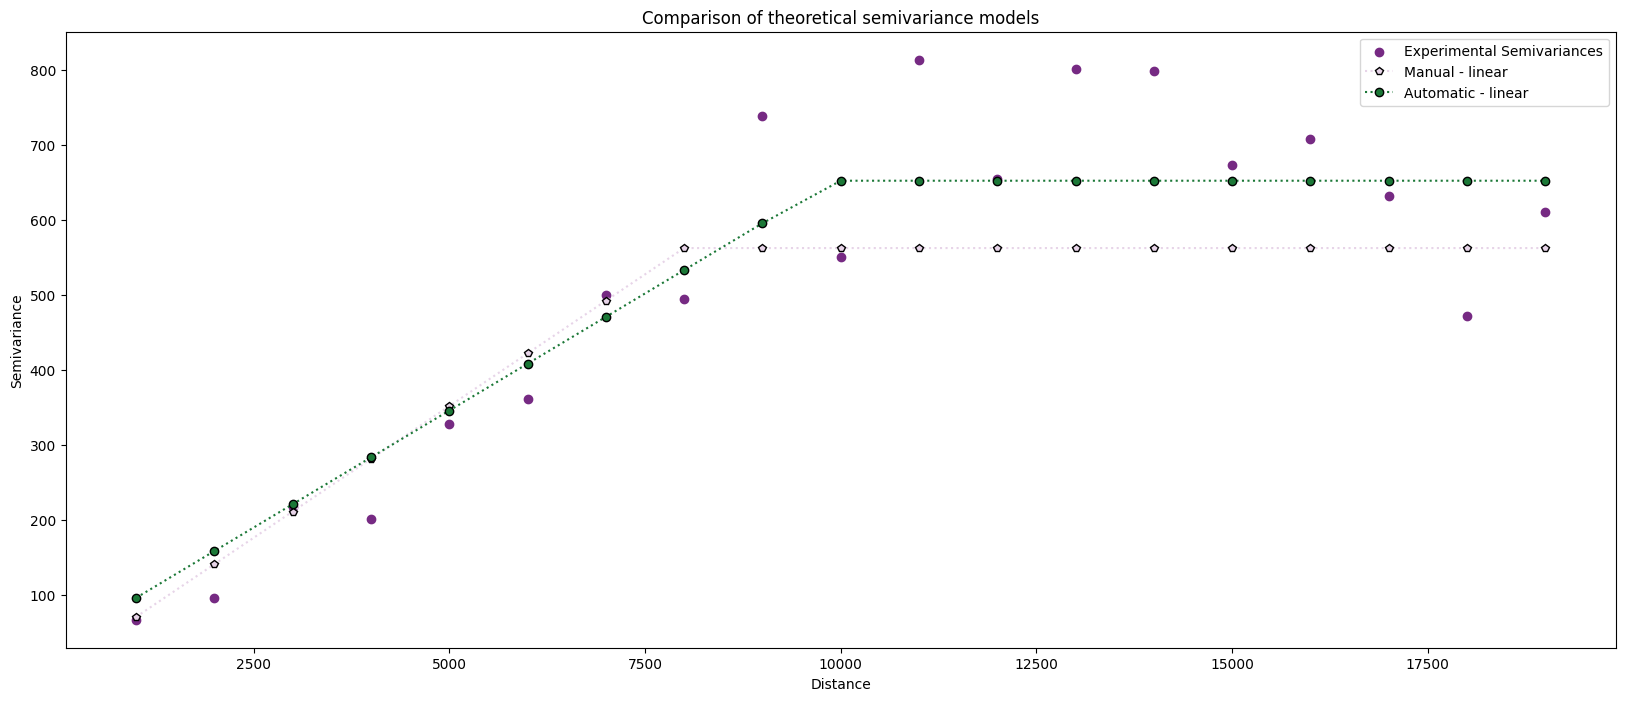

In [36]:
_lags = experimental_variogram.lags
_experimental = experimental_variogram.semivariances
_linear_manual = linear_model.yhat
_automatic = fitted.yhat

plt.figure(figsize=(20, 8))
plt.scatter(_lags, _experimental, color='#762a83')  # Experimental
plt.plot(_lags, _linear_manual, ':p', color='#e7d4e8', mec='black')
plt.plot(_lags, _automatic, ':o', color='#1b7837', mec='black')

plt.title('Comparison of theoretical semivariance models')
plt.legend(['Experimental Semivariances',
            'Manual - ' + linear_model.name,
            'Automatic - ' + fitted.name])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

## Eksport Modelu

Czasami Kriging jest przeprowadzany w innym skrypcie albo posługujemy się jednym modelem semiwariogramu dla jednego obszaru przez dłuższy czas (na przykład interpolując pomiary temperatury ze stacji pogowych, w trakcie jednej pory roku). Zamiast estymować semiwariogram na nowo za każdym razem, kiedy przeprowadzana jest interpolacja, można zapisać jego parametry w postaci pliku JSON (albo eksportować je do obiektu typu `dict`).

Mamy dwie opcje eksportu:
- `.to_dict()` - parametry trafiają do słownika Pythona
- `.to_json()` - parametry zapisywane są w pliku JSON.

In [37]:
dict_representation = fitted.to_dict()

In [38]:
dict_representation

{'experimental_variogram': None,
 'nugget': 33.25175378437421,
 'sill': 618.5743674621095,
 'rang': 9909.246544791626,
 'variogram_model_type': 'linear',
 'direction': None,
 'spatial_dependence': None,
 'spatial_index': None,
 'yhat': None,
 'errors': None}

In [39]:
# Zapis do pliku JSON

fitted.to_json('fitted.json')

## Import modelu

Skoro semiwariogram może zostać eksportowany, to może być również importowany. Nie trzeba wtedy dołączać obserwacji na podstawie których teoretyczny semiwariogram został estymowany, podobnie nie trzeba dołączać eksperymentalnych punktów. Analogicznie do eksportu, mamy dwie metody klasy `TheoreticalVariogram`, które wywołujemy na **pustym** czyli dopiero zainicjowanym obiekcie tego typu:

- `.from_dict()` - parametry wczytywane są ze słownika,
- `.from_json()` - parametry wczytywane są z pliku JSON.

In [41]:
model_from_dict = TheoreticalVariogram()
model_from_dict.from_dict(dict_representation)

In [42]:
print(model_from_dict)

* Selected model: Linear model
* Nugget: 33.25175378437421
* Sill: 618.5743674621095
* Range: 9909.246544791626
* Spatial Dependency Strength is strong
* Mean Bias: 0.0
* Mean RMSE: 0.0
* Error-lag weighting dir_neighbors_selection_method: None


In [43]:
model_from_json = TheoreticalVariogram()
model_from_json.from_json('fitted.json')

In [44]:
print(model_from_json)

* Selected model: Linear model
* Nugget: 33.25175378437421
* Sill: 618.5743674621095
* Range: 9909.246544791626
* Spatial Dependency Strength is strong
* Mean Bias: 0.0
* Mean RMSE: 0.0
* Error-lag weighting dir_neighbors_selection_method: None


To wszystko w tym samouczku, gratulacje!

-----

## Dziennik zmian

| Data       | Zmiany                                   | Autor                            |
|------------|------------------------------------------|----------------------------------|
| 2025-08-17 | Samouczek przetłumaczony na język polski | @SimonMolinsky (Szymon Moliński) |